In [88]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [48]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [2]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()
path = "medium-sparkify-event-data.json"
spark_df = spark.read.json(path)



In [3]:
spark_df.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

## Clean and Transformation

In [4]:
# remove empyt user ID and sessionID
spark_df_clean=spark_df.filter(spark_df["userId"]!="")
spark_df_clean=spark_df_clean.dropna(how="any",subset=["userId",'sessionId'])

In [5]:
# convert ts to real time
gen_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
spark_df_clean = spark_df_clean.withColumn("time", gen_time(spark_df_clean['ts']))

In [6]:
# get hour, weekday and day
gen_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
spark_df_clean = spark_df_clean.withColumn("hour", gen_hour(spark_df_clean['ts']))

gen_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
spark_df_clean = spark_df_clean.withColumn("weekday", gen_weekday(spark_df_clean['ts']))

gen_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
spark_df_clean = spark_df_clean.withColumn("day", gen_day(spark_df_clean['ts']))

In [7]:
# convert location to state
# the location column contains the city name and the state name. This cell is used to remove the city and only keep the state name
get_state=udf(lambda x:x[-2:])
spark_df_clean = spark_df_clean.withColumn("location_state", get_state(spark_df_clean['location']))

In [8]:
# simplify userAgent
# userAgent contains the system and software info of each customer. To simplify userAgent, I only kept the system info. for example, Macintosh, or Windows NT
simp_useragent=udf(lambda x:"".join(x[x.index('(')+1:x.index(')')]))
spark_df_clean= spark_df_clean.withColumn("sim_user_agent", simp_useragent(spark_df_clean['userAgent']))

In [9]:
# create a churn column, if a customer has cancel confirmation in his/her page column, the churn value will be 1 in all rows of this customer.
get_cancel=udf(lambda x:1 if x=='Cancellation Confirmation' else 0)
spark_df_clean=spark_df_clean.withColumn("Churn",get_cancel(spark_df_clean['page']))

churnlist=spark_df_clean.filter(spark_df_clean["Churn"]==1).select('userId').dropDuplicates().collect()
churn_list=[x['userId'] for x in churnlist]
assign_churn=udf(lambda x:1 if x in churn_list else 0)
spark_df_clean=spark_df_clean.withColumn("Churn",assign_churn(spark_df_clean['userId']))

In [10]:
# create a downgrade column, if a customer has cancel confirmation in his/her page column, the churn value will be 1 in all rows of this customer.
get_downgrade=udf(lambda x:1 if x=='Downgrade' else 0)
spark_df_clean=spark_df_clean.withColumn("Downgrade",get_cancel(spark_df_clean['page']))

downgradelist=spark_df_clean.filter(spark_df_clean["Downgrade"]==1).select('userId').dropDuplicates().collect()
downgrade_list=[x['userId'] for x in downgradelist]
assign_downgrade=udf(lambda x:1 if x in downgrade_list else 0)
spark_df_clean=spark_df_clean.withColumn("Downgrade",assign_downgrade(spark_df_clean['userId']))

## Data Exploration-Stage 1

#### Gender distribution between churn user and normal user

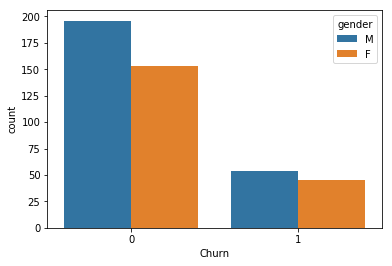

In [11]:
df_gender=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "gender"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='gender', data=df_gender)

The data is imbalanced. We have more normal user than Churn user. We probably need to pay attention when creating the model

#### level distribution between churn user and normal user

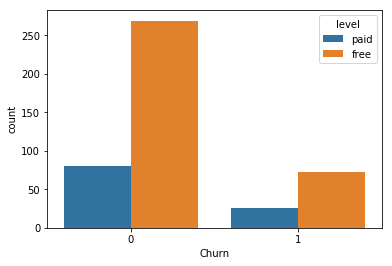

In [12]:
df_level=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "level"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='level', data=df_level)

#### method distribution between churn user and normal user

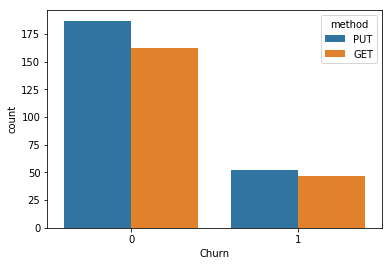

In [13]:
df_method=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "method"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='method', data=df_method)

#### location(state) distribution between churn and normal user

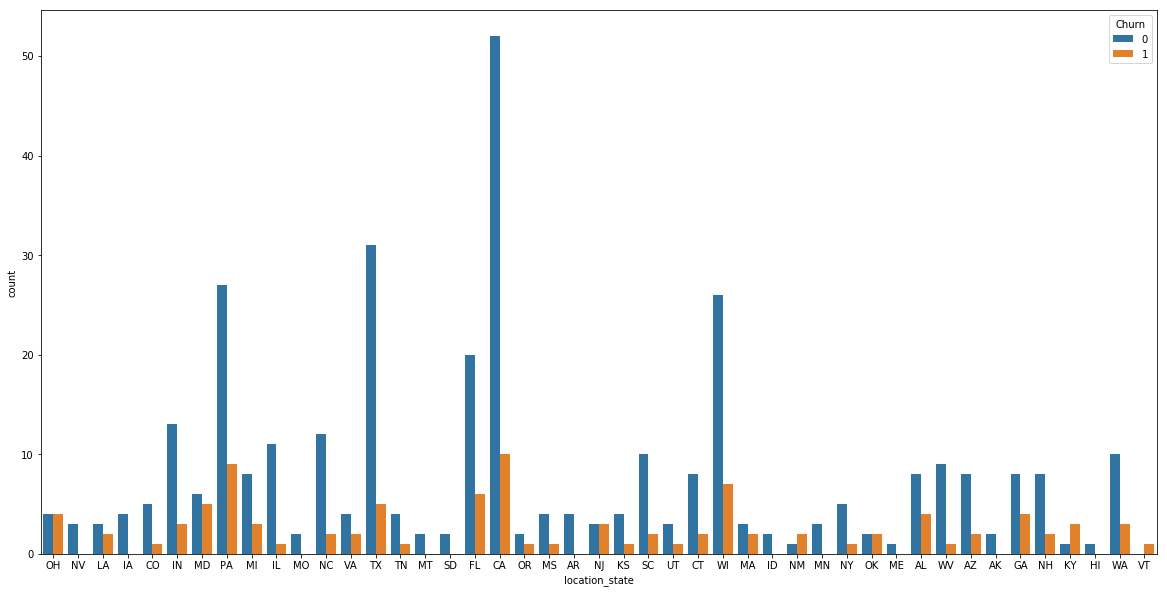

In [14]:
plt.figure(figsize=(20,10))
df_state=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "location_state"]).count().sort("Churn").toPandas()
sns.barplot(x='location_state', y='count', hue='Churn', data=df_state)

#### page distribution between churn user and normal user

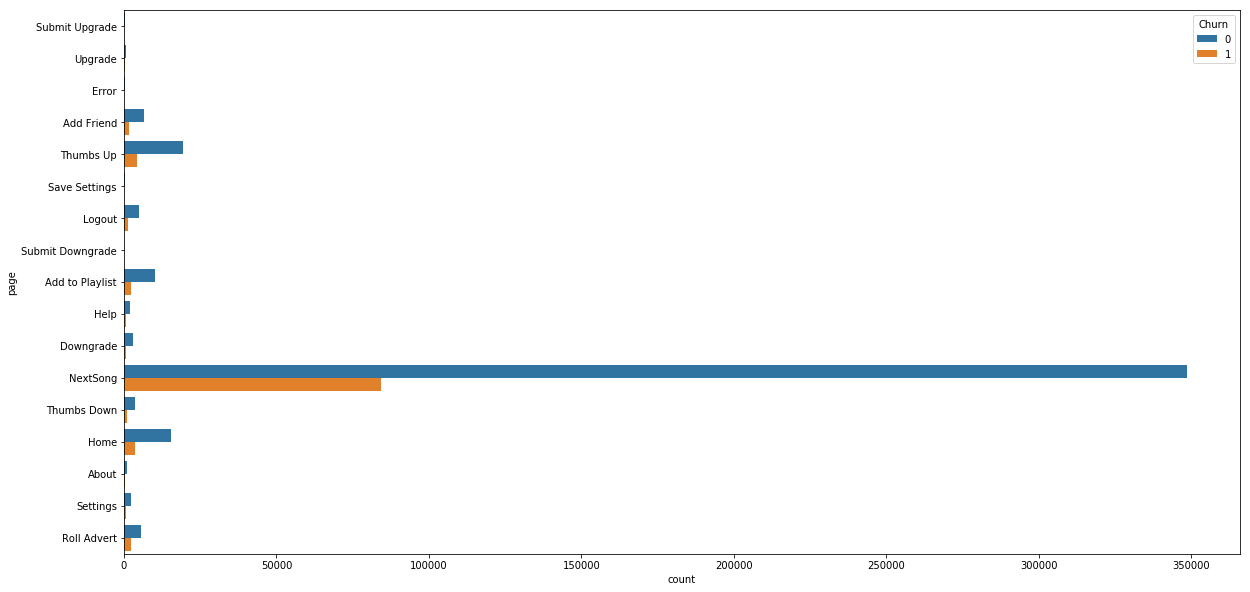

In [15]:
df_page=spark_df_clean.groupby(["Churn", "page"]).count().sort("Churn").toPandas()
df_page=df_page[(df_page['page']!="Cancellation Confirmation")&(df_page['page']!="Cancel")]
plt.figure(figsize=(20,10))
sns.barplot(x='count', y='page', hue='Churn', data=df_page)

#### Time(hours in a day, days in a week, days in a month) distribution for churn user and normal user

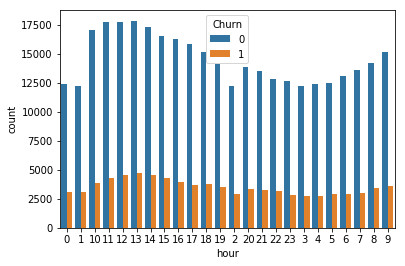

In [16]:
df_hour=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby(["Churn", "hour"]).count().sort("Churn").toPandas()
sns.barplot(x='hour', y='count', hue='Churn', data=df_hour)

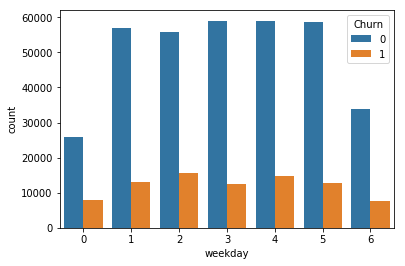

In [17]:
df_weekday=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby(["Churn", "weekday"]).count().sort("Churn").toPandas()
sns.barplot(x='weekday', y='count', hue='Churn', data=df_weekday)

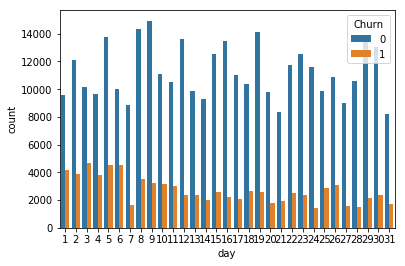

In [18]:
df_day=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby(["Churn", "day"]).count().sort("day").toPandas()
df_day['day']=pd.to_numeric(df_day['day'])
df_day=df_day.sort_values('day')
sns.barplot(x='day', y='count', hue='Churn', data=df_day)

based on the plots above, it seems that the original features in the data did not provide much insight between churn user and normal user. Therefore, I may need to create some new features from the current features to dig out more insight.

## Feature Engineering

In [19]:
# get user ID
user_list=spark_df_clean.select('userId').dropDuplicates().sort('userId').toPandas()['userId']
user_list=list(user_list)

In [20]:
#create feature dataframe
feature_index=np.arange(0,len(user_list))
feature_df=pd.DataFrame(index=feature_index)
feature_df['userId']=user_list

In [21]:
# add gender
feature_df['gender']=spark_df_clean.select('userId','gender').dropDuplicates().sort('userId').toPandas()['gender']

In [22]:
# Add level
feature_df['level']=spark_df_clean.select('userId','level').dropDuplicates().sort('userId').toPandas()['level']

In [23]:
# Add method
feature_df['method']=spark_df_clean.select('userId','method').dropDuplicates().sort('userId').toPandas()['method']

In [24]:
# Add location_state
feature_df['location_state']=spark_df_clean.select('userId','location_state').dropDuplicates().sort('userId').toPandas()['location_state']

In [25]:
# Add user_agent
feature_df['user_agent']=spark_df_clean.select('userId','sim_user_agent').dropDuplicates().sort('userId').toPandas()['sim_user_agent']

In [26]:
# page
# first create a data frame to that contains the user ID
temp_df_feature=spark_df_clean.select('userId').dropDuplicates().sort('userId').toPandas()

In [27]:
# page
# get page list and cout usage of total page
# everytime a user click an option in page feature, a record will be generated. So all we need to do is to count how many records are there for each user
page_list = [(row['page']) for row in spark_df_clean.select("page").dropDuplicates().collect()]
page_view_total_count=spark_df_clean.groupby("userId").count().sort('userId').toPandas()

In [28]:
removelist=['Cancel','Submit Downgrade','Downgrade','Cancellation Confirmation']
for i in removelist:
    page_list.remove(i)

In [29]:
page_list

['Thumbs Down',
 'Home',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [30]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    result=pd.merge(df1,df2,on='userId',how='left')
    return result

In [31]:
temp_df_feature=features_merge(temp_df_feature,page_view_total_count)

In [32]:
# create features relative to page
# first I need to extract how many times each page feature was used for each user. And the total time interval between the user first click this feature and last click on this feature

In [33]:
for page in page_list:
    
    col_name = "count_" + page.replace(" ", "_")
    col_name_2="totalts_" + page.replace(" ", "")
    temp_page_count=spark_df_clean.filter(spark_df_clean['page']==page).groupby("userId").count().sort('userId').toPandas()   
    temp_page_mints=spark_df_clean.filter(spark_df_clean['page']==page).groupby("userId").min('ts').sort('userId').toPandas()['min(ts)']
    temp_page_maxts=spark_df_clean.filter(spark_df_clean['page']==page).groupby("userId").max('ts').sort('userId').toPandas()['max(ts)']
    temp_page_count[col_name]=temp_page_count['count']
    temp_page_count.drop(columns=['count'],inplace=True)
    temp_page_count[col_name_2]=temp_page_maxts-temp_page_mints
    
    temp_df_feature=features_merge(temp_df_feature,temp_page_count)
    

In [34]:
# next, I want to get the percentage of each page feature interaction in total page features interaction and the frequency of each page feature usage

In [ ]:
# -----------------------------------------------------------------

In [ ]:
#checkpoint

In [ ]:
temp_df_feature.to_csv('temp_df_feature.csv',index=False)

In [ ]:
feature_df.to_csv('feature_df.csv',index=False)

In [ ]:
# relaod checkpoint

In [ ]:
temp_df_feature=pd.read_csv('temp_df_feature.csv')
feature_df=pd.read_csv('feature_df.csv')
page_list=['Thumbs Down','Home','Roll Advert','Logout','Save Settings','About','Settings','Add to Playlist','Add Friend','NextSong','Thumbs Up','Help','Upgrade','Error','Submit Upgrade']

In [ ]:
# -----------------------------------------------------------------

In [35]:

for page in page_list:
    col_name = "count_" + page.replace(" ", "_")
    col_name_2="totalts_" + page.replace(" ", "")
    col_name_3="percentage_" + page.replace(" ", "_")
    col_name_4="freq_" + page.replace(" ", "_")
    temp_df_feature[col_name_3]=np.array(temp_df_feature[col_name])/(np.array(temp_df_feature['count'])+1)
    temp_df_feature[col_name_4]=np.array(temp_df_feature[col_name])/(np.array(temp_df_feature[col_name_2])/1000/60/60+1)   # convert the unit to times/hour
    temp_df_feature.drop(columns=[col_name,col_name_2],inplace=True)

temp_df_feature.drop(columns=['count'],inplace=True)

In [36]:
temp_df_feature.head()

,userId,percentage_Thumbs_Down,freq_Thumbs_Down,percentage_Home,freq_Home,percentage_Roll_Advert,freq_Roll_Advert,percentage_Logout,freq_Logout,percentage_Save_Settings,...,percentage_Thumbs_Up,freq_Thumbs_Up,percentage_Help,freq_Help,percentage_Upgrade,freq_Upgrade,percentage_Error,freq_Error,percentage_Submit_Upgrade,freq_Submit_Upgrade
0,10,0.002358,1.000000,0.035377,0.616988,NaN,NaN,0.009434,0.187254,NaN,...,0.040094,0.749807,0.007075,0.289358,NaN,NaN,0.002358,1.000000,NaN,NaN
1,100,0.009250,0.026585,0.033750,0.092597,0.002000,0.006201,0.009000,0.024734,0.000500,...,0.035750,0.100280,0.004250,0.012358,0.000250,1.000000,0.000750,0.011893,0.000250,1.0
2,100001,0.007407,1.000000,0.029630,0.132314,0.096296,0.400137,0.014815,0.092002,NaN,...,0.037037,0.166512,0.007407,1.000000,0.014815,0.066240,NaN,NaN,NaN,NaN
3,100002,0.011236,0.543683,0.067416,0.021210,0.028090,0.008837,0.016854,0.009889,NaN,...,0.044944,0.014177,0.011236,0.003546,0.005618,1.000000,NaN,NaN,0.005618,1.0
4,100003,0.012077,0.014103,0.037440,0.043613,0.049517,0.057554,0.014493,0.016964,0.001208,...,0.019324,0.023507,0.003623,0.007346,0.002415,0.006898,0.001208,1.000000,0.001208,1.0


In [37]:
feature_df=features_merge(feature_df,temp_df_feature)

In [38]:
# numbers of days after reigstration
user_max_time = spark_df_clean.groupby("userId").max("ts").sort("userId").select('max(ts)').collect()
user_reg_time = spark_df_clean.select("userId", "registration").dropDuplicates().sort("userId").select('registration').collect()
number_of_days=(np.array(user_max_time)-np.array(user_reg_time))/(60*60*24*1000)
feature_df['number of days']=number_of_days

In [39]:
# add feature about sessions
# first create a dataframe that contains the total listening time of each session for each user
sessiontime_sparkdf=spark_df_clean.groupby("userId",'sessionId').agg(((max(spark_df_clean['ts'])-min(spark_df_clean['ts']))/1000/60).alias('sessiontime')).sort('userId','sessionId')

In [40]:
# the number of session each user listened
feature_df['session_count']=np.array(sessiontime_sparkdf.groupby("userId").count().sort('userId').select('count').collect())

In [41]:
#count the max session time per user
feature_df['max_sessiontime']=np.array(sessiontime_sparkdf.groupby("userId").max('sessiontime').sort('userId').select('max(sessiontime)').collect())

In [42]:
#count the min session time per user
feature_df['min_sessiontime']=np.array(sessiontime_sparkdf.groupby("userId").min('sessiontime').sort('userId').select('min(sessiontime)').collect())

In [43]:
# count the avg session time per user
feature_df['avg_sessiontime']=np.array(sessiontime_sparkdf.groupby("userId").avg('sessiontime').sort('userId').select('avg(sessiontime)').collect())

In [44]:
# add features relative to song
spark_df.createOrReplaceTempView("spark_df_table")
spark.sql('''
            SELECT *
            FROM spark_df_table
            WHERE (song IS NULL OR artist IS NULL) AND page = 'NextSong'
          '''
         ).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



in the raw data, if page is not NextSong, than the artist and song value will be null. So if we want count the number of song feature for each user or session, we need to select rows with page value = NextSong

In [45]:
song_sparkdf=spark_df_clean.filter(spark_df_clean['page']=="NextSong").groupby("userId",'sessionId').count().sort('userId','sessionId')
# add max number of songs per session
feature_df['max_session_songs']=np.array(song_sparkdf.groupby("userId").max('count').sort('userId').select('max(count)').collect())
# add min number of songs per session
feature_df['min_session_songs']=np.array(song_sparkdf.groupby("userId").min('count').sort('userId').select('min(count)').collect())
# add avg number of songs per session
feature_df['avg_session_songs']=np.array(song_sparkdf.groupby("userId").avg('count').sort('userId').select('avg(count)').collect())
# add total number of songs per user listened
feature_df['total_songs']=np.array(song_sparkdf.groupby("userId").sum('count').sort('userId').select('sum(count)').collect())

In [46]:
# add number of unique song each user played
song_featuredf2=spark_df_clean.filter(spark_df_clean['page']=="NextSong").groupby("userId",'song').count().sort("userId")
feature_df['diff_song_per_user']=np.array(song_featuredf2.groupby("userId").count().select('count').collect())

In [47]:
# the play times of the most frequently played song
feature_df['most_played_song_number']=np.array(song_featuredf2.groupby("userId").max('count').select('max(count)').collect())

In [48]:
# feature about artists
# the number of different artists each user listened
feature_df['artist_number']=np.array(spark_df_clean.filter(spark_df_clean['page']=="NextSong").groupby("userId",'artist').count().sort("userId").groupby("userId").count().select('count').collect())

In [49]:
# add churn and downgrade column
feature_df['churn']=np.array(spark_df_clean.dropDuplicates(['userId']).sort('userId').select('Churn').collect())
feature_df['downgrade']=np.array(spark_df_clean.dropDuplicates(['userId']).sort('userId').select('downgrade').collect())

In [50]:
feature_df.head()

,userId,gender,level,method,location_state,user_agent,percentage_Thumbs_Down,freq_Thumbs_Down,percentage_Home,freq_Home,...,avg_sessiontime,max_session_songs,min_session_songs,avg_session_songs,total_songs,diff_song_per_user,most_played_song_number,artist_number,churn,downgrade
0,10,M,paid,GET,MS,Macintosh; Intel Mac OS X 10_9_4,0.002358,1.000000,0.035377,0.616988,...,1502.400000,360,360,360.000000,360,350,4,306,1,1
1,100,M,paid,PUT,TX,Windows NT 6.1; WOW64; rv:30.0,0.009250,0.026585,0.033750,0.092597,...,350.477778,405,1,86.717949,3382,2835,21,1963,0,0
2,100001,F,free,GET,FL,Macintosh; Intel Mac OS X 10_6_8,0.007407,1.000000,0.029630,0.132314,...,137.661111,47,10,32.000000,96,96,1,93,1,1
3,100002,F,free,PUT,CA,Windows NT 6.1; WOW64; rv:32.0,0.011236,0.543683,0.067416,0.021210,...,150.262500,73,14,34.250000,137,136,2,128,0,0
4,100003,F,paid,PUT,FL,Windows NT 6.1; WOW64; rv:31.0,0.012077,0.014103,0.037440,0.043613,...,296.927778,319,2,82.625000,661,625,4,545,1,1


In [51]:
feature_df=feature_df.fillna(0)

In [52]:
feature_df.to_csv('feature_df.csv',index=False)

In [53]:
print(feature_df.columns)

Index(['userId', 'gender', 'level', 'method', 'location_state', 'user_agent',
       'percentage_Thumbs_Down', 'freq_Thumbs_Down', 'percentage_Home',
       'freq_Home', 'percentage_Roll_Advert', 'freq_Roll_Advert',
       'percentage_Logout', 'freq_Logout', 'percentage_Save_Settings',
       'freq_Save_Settings', 'percentage_About', 'freq_About',
       'percentage_Settings', 'freq_Settings', 'percentage_Add_to_Playlist',
       'freq_Add_to_Playlist', 'percentage_Add_Friend', 'freq_Add_Friend',
       'percentage_NextSong', 'freq_NextSong', 'percentage_Thumbs_Up',
       'freq_Thumbs_Up', 'percentage_Help', 'freq_Help', 'percentage_Upgrade',
       'freq_Upgrade', 'percentage_Error', 'freq_Error',
       'percentage_Submit_Upgrade', 'freq_Submit_Upgrade', 'number of days',
       'session_count', 'max_sessiontime', 'min_sessiontime',
       'avg_sessiontime', 'max_session_songs', 'min_session_songs',
       'avg_session_songs', 'total_songs', 'diff_song_per_user',
       'most_played

## Data exploration-Stage 2

In [54]:
total_feature_name=list(feature_df.columns)

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: most_played_song_number, dtype: object

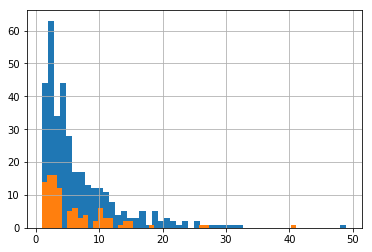

In [55]:
feature_df.groupby(['churn'])['most_played_song_number'].hist(bins=50)

E:\Users\xbxb\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
E:\Users\xbxb\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
E:\Users\xbxb\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDep

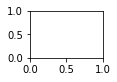

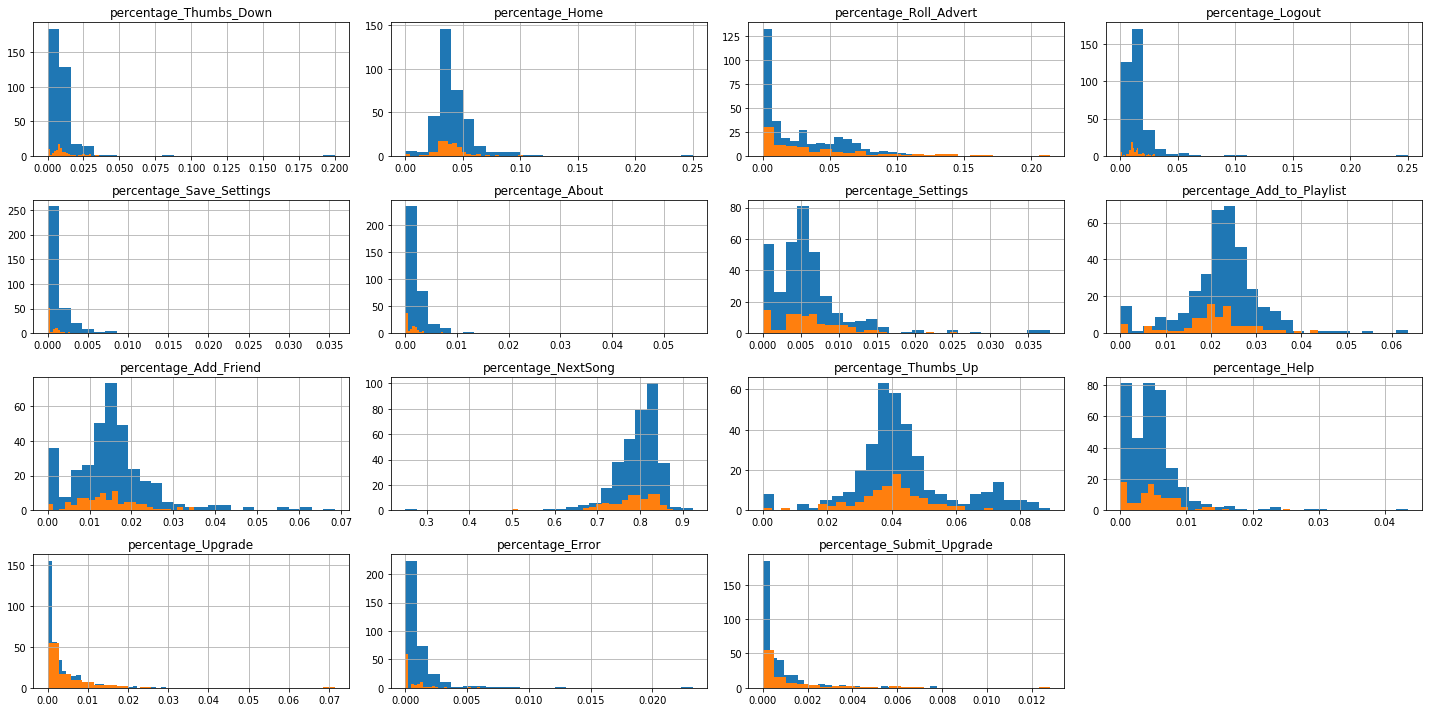

In [56]:
plt.subplot(441)
plt.figure(figsize=(20,10))
count=1
for i in total_feature_name:
    if "percentage" in i:
        feature_df.groupby(['churn'])[i].hist(bins=25,ax=plt.subplot(4, 4, count))
        plt.subplot(4, 4, count).set_title(i)
        count=count+1
plt.tight_layout()

E:\Users\xbxb\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
E:\Users\xbxb\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
E:\Users\xbxb\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDep

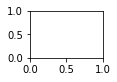

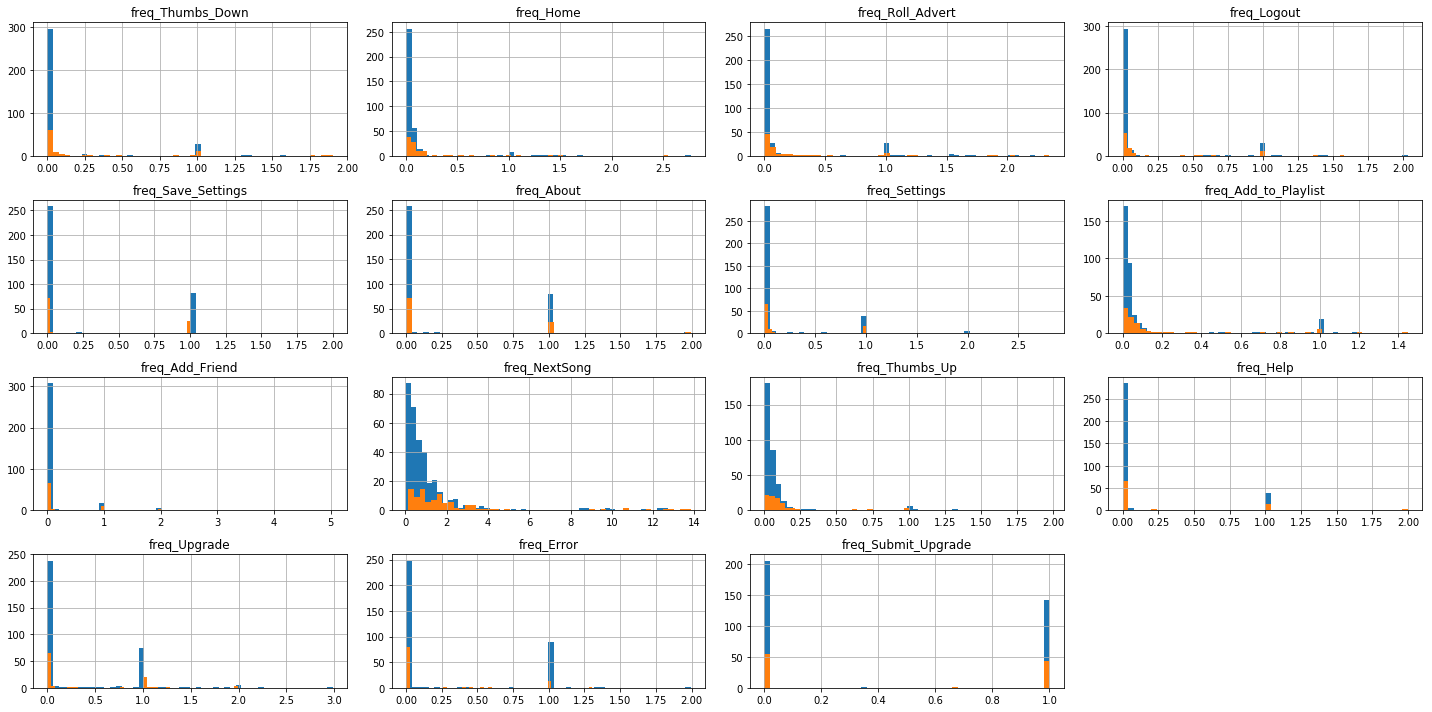

In [57]:
plt.subplot(441)
plt.figure(figsize=(20,10))
count=1
for i in total_feature_name:
    if "freq" in i:
        feature_df.groupby(['churn'])[i].hist(bins=50,ax=plt.subplot(4, 4, count))
        plt.subplot(4, 4, count).set_title(i)
        count=count+1
plt.tight_layout()

E:\Users\xbxb\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
E:\Users\xbxb\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
E:\Users\xbxb\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDep

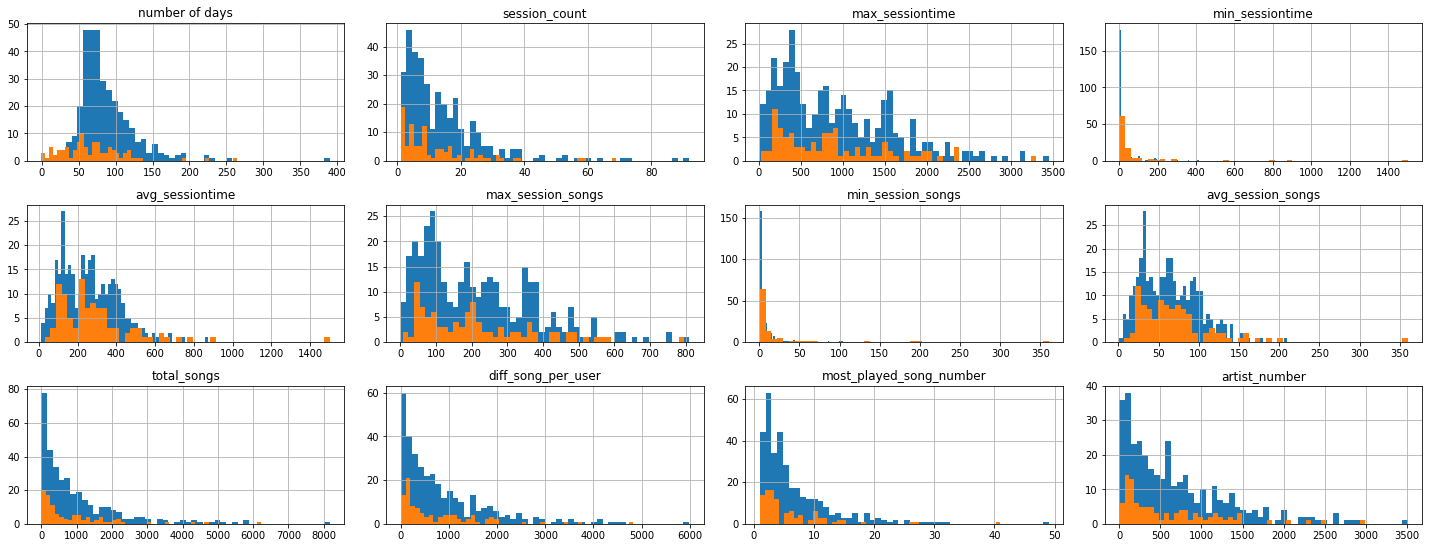

In [58]:
plt.figure(figsize=(20,10))
plt.subplot(441)

count=1
for i in total_feature_name:
    if ("freq" not in i) and ("percentage" not in i) and (i not in ['userId','churn','downgrade','gender', 'level', 'method', 'location_state', 'user_agent']) :
        feature_df.groupby(['churn'])[i].hist(bins=50,ax=plt.subplot(4, 4, count))
        plt.subplot(4, 4, count).set_title(i)
        count=count+1
plt.tight_layout()

# Modeling

In [5]:
df= spark.read.csv('feature_df.csv', header=True)

### cat featuring encoding

In [8]:
stringIndexer1 = StringIndexer(inputCol="gender", outputCol="gender_index")
model1 = stringIndexer1.fit(df)
df = model1.transform(df)

In [9]:
stringIndexer2 = StringIndexer(inputCol="level", outputCol="level_index")
model2 = stringIndexer2.fit(df)
df = model2.transform(df)

In [10]:
stringIndexer3 = StringIndexer(inputCol="location_state", outputCol="location_state_index")
model3 = stringIndexer3.fit(df)
df = model3.transform(df)

In [12]:
stringIndexer4 = StringIndexer(inputCol="user_agent", outputCol="user_agent_index")
model4 = stringIndexer4.fit(df)
df = model4.transform(df)

In [13]:
encoder = OneHotEncoderEstimator(inputCols=["gender_index","level_index","location_state_index","user_agent_index"],
                                outputCols=["gender_var","level_var","location_state_var","user_agent_var"])
model = encoder.fit(df)
df = model.transform(df)

In [14]:
df=df.drop("gender","level","method","location_state","user_agent","gender_index","level_index","location_state_index","user_agent_index")

### Numerical features encoding

In [16]:
# convert all string type numerical values to float
num_features_list = df.columns[1:-4]
for f in num_features_list:
    f_name = f + "_Num"
    df = df.withColumn(f_name, df[f].cast("float"))
    df = df.drop(f)

### Vector Assembler

In [17]:
assembler = VectorAssembler(inputCols=df.columns[1:-2], outputCol="Features")
data = assembler.transform(df)

### Standard scaler

In [18]:
scaler = StandardScaler(inputCol="Features", outputCol="StdFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

### PCA

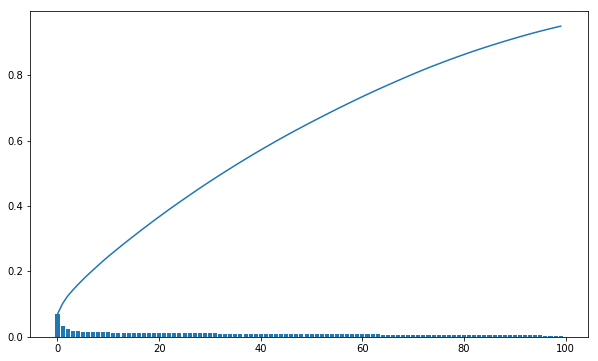

In [19]:
pca = PCA(k=100, inputCol="StdFeatures", outputCol="pcaFeatures")
model = pca.fit(data)

ind=np.arange(100)
val=np.array(model.explainedVariance)
cumvals=np.cumsum(val)
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.bar(ind, val)
ax.plot(ind,cumvals)

use 0.005 as threshold, any components that are less than 0.005 variance will not be used

In [26]:
k=len(val[val>0.005])

In [27]:
print(k)

86


In [28]:
pca = PCA(k=86, inputCol="StdFeatures", outputCol="pcaFeatures")
model = pca.fit(data)
data = model.transform(data)

### split the data

In [29]:
data_churn = data.select(data.churn_Num.alias("label"), data.pcaFeatures.alias("features"))
data_down=data.select(data.downgrade_Num.alias("label"), data.pcaFeatures.alias("features"))

In [30]:
data_churn.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   99|
|  0.0|  349|
+-----+-----+



Appearently, the data is imbalanced.

In [31]:
train, validation = data_churn.randomSplit([0.8, 0.2], seed=110)

In [32]:
train.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   80|
|  0.0|  279|
+-----+-----+



###  handle unbalanced data

In [119]:
# method 1, Augmentation
oversampled_train=train.sample(True, 2.0, 110)
oversampled_train.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|  150|
|  0.0|  566|
+-----+-----+



In [153]:
# method 2, under sample the popular class
stratified_train = train.sampleBy('label', fractions={0: 0.3, 1: 1.0}).cache()
stratified_train.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   80|
|  0.0|   86|
+-----+-----+



In [154]:
# method 3,Augmentation then under sample the popular class
stratified_train2 = oversampled_train.sampleBy('label', fractions={0: 0.3, 1: 1.0}).cache()
stratified_train2.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|  150|
|  0.0|  171|
+-----+-----+



### Model training and cross validation

In [155]:
# define the evaluation metrics
def evaluate_result(results,model_name):
    print(model_name," f1 score: ", MulticlassClassificationEvaluator(metricName="f1").evaluate(results))
    print(model_name," accuracy: ", MulticlassClassificationEvaluator(metricName="accuracy").evaluate(results))
    rdd=results.select('label','prediction').rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(rdd)
    print("label 1 recall: ", metrics.recall(1),", precision: ",metrics.precision(1))
    print("label 0 recall: ", metrics.recall(0),", precision: ",metrics.precision(0))
    pass

In [156]:
def three_modelcomparison(train,validation):
    lr =  LogisticRegression(featuresCol = 'features', labelCol = 'label')
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.2]) \
        .addGrid(lr.regParam,[0.0, 0.1, 0.2, 0.3]) \
        .addGrid(lr.maxIter,[5, 10, 15, 20, 25]) \
        .build()

    crossval_lr = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=10)
    cvModel_lr = crossval_lr.fit(train)
    lr_avgMetrics=cvModel_lr.avgMetrics
    results_lr = cvModel_lr.transform(validation)
    evaluate_result(results_lr,"logistic regression")
    #--------------------------------------------------------
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',)
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.impurity,['entropy','gini']) \
        .addGrid(rf.maxDepth,[10, 15, 20, 25]) \
        .addGrid(rf.numTrees,[20, 30, 40]) \
        .build()
    crossval_rf = CrossValidator(estimator=rf,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=10)
    cvModel_rf= crossval_rf.fit(train)
    rf_avgMetrics = cvModel_rf.avgMetrics
    results_rf = cvModel_rf.transform(validation)
    evaluate_result(results_rf,"random forest")
    #-----------------------------------------------------------
    gbts = GBTClassifier()
    paramGrid = ParamGridBuilder() \
        .addGrid(gbts.maxIter,[20, 30, 40]) \
        .addGrid(gbts.maxDepth,[2, 4, 6, 8]) \
        .build()
    crossval_gbts = CrossValidator(estimator=gbts,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=10)
    cvModel_gbts = crossval_gbts.fit(train)
    gbts_avgMetrics = cvModel_gbts.avgMetrics
    results_gbts = cvModel_gbts.transform(validation)
    evaluate_result(results_gbts,"GBT")
    return cvModel_lr,cvModel_rf,cvModel_gbts

In [157]:
lr_model1,rf_model1,gbts_model1=three_modelcomparison(oversampled_train,validation)

logistic regression  f1 score:  0.7060645347162201
logistic regression  accuracy:  0.6853932584269663
label 1 recall:  0.5263157894736842 , precision:  0.3448275862068966
label 0 recall:  0.7285714285714285 , precision:  0.85
random forest  f1 score:  0.7345800267148581
random forest  accuracy:  0.797752808988764
label 1 recall:  0.10526315789473684 , precision:  0.6666666666666666
label 0 recall:  0.9857142857142858 , precision:  0.8023255813953488
GBT  f1 score:  0.7513918412794816
GBT  accuracy:  0.7752808988764045
label 1 recall:  0.2631578947368421 , precision:  0.45454545454545453
label 0 recall:  0.9142857142857143 , precision:  0.8205128205128205


In [158]:
lr_model2,rf_model2,gbts_model2=three_modelcomparison(stratified_train,validation)

logistic regression  f1 score:  0.6110680614748805
logistic regression  accuracy:  0.5730337078651685
label 1 recall:  0.5263157894736842 , precision:  0.2564102564102564
label 0 recall:  0.5857142857142857 , precision:  0.82
random forest  f1 score:  0.5701278574196048
random forest  accuracy:  0.5280898876404494
label 1 recall:  0.42105263157894735 , precision:  0.20512820512820512
label 0 recall:  0.5571428571428572 , precision:  0.78
GBT  f1 score:  0.6181556073775706
GBT  accuracy:  0.5842696629213483
label 1 recall:  0.42105263157894735 , precision:  0.23529411764705882
label 0 recall:  0.6285714285714286 , precision:  0.8


In [159]:
lr_model3,rf_model3,gbts_model3=three_modelcomparison(stratified_train2,validation)

logistic regression  f1 score:  0.7083988764044944
logistic regression  accuracy:  0.6853932584269663
label 1 recall:  0.5789473684210527 , precision:  0.3548387096774194
label 0 recall:  0.7142857142857143 , precision:  0.8620689655172413
random forest  f1 score:  0.7018075996553605
random forest  accuracy:  0.7078651685393258
label 1 recall:  0.2631578947368421 , precision:  0.29411764705882354
label 0 recall:  0.8285714285714286 , precision:  0.8055555555555556
GBT  f1 score:  0.6909258164136933
GBT  accuracy:  0.6741573033707865
label 1 recall:  0.42105263157894735 , precision:  0.3076923076923077
label 0 recall:  0.7428571428571429 , precision:  0.8253968253968254


In [81]:
lr =  LogisticRegression(featuresCol = 'features', labelCol = 'label')
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.2]) \
    .addGrid(lr.regParam,[0.0, 0.1, 0.2, 0.3]) \
    .addGrid(lr.maxIter,[5, 10, 15]) \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)
cvModel_lr = crossval_lr.fit(oversampled_train)
lr_avgMetrics=cvModel_lr.avgMetrics

In [82]:
results_lr = cvModel_lr.transform(validation)

In [103]:
evaluate_result(results_lr,"logistic regression")

logistic regression  f1 score:  0.6968389655313392
logistic regression  accuracy:  0.6741573033707865
label 1 recall:  0.5263157894736842 , precision:  0.3333333333333333
label 0 recall:  0.7142857142857143 , precision:  0.847457627118644


In [113]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity,['entropy']) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .addGrid(rf.numTrees,[10, 20, 30]) \
    .build()
crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

In [114]:
cvModel_rf= crossval_rf.fit(oversampled_train)
rf_avgMetrics = cvModel_rf.avgMetrics
results_rf = cvModel_rf.transform(validation)
evaluate_result(results_rf,"random forest")

random forest  f1 score:  0.6985202578123768
random forest  accuracy:  0.7640449438202247
label 1 recall:  0.05263157894736842 , precision:  0.25
label 0 recall:  0.9571428571428572 , precision:  0.788235294117647


In [115]:
cvModel_rf.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_93146d79ba89', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_93146d79ba89', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_93146d79ba89', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_93146d79ba89', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_93146d79ba89', 

In [117]:
gbts = GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(gbts.maxIter,[3, 10, 20]) \
    .addGrid(gbts.maxDepth,[2, 4, 6, 8]) \
    .build()
crossval_gbts = CrossValidator(estimator=gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)
cvModel_gbts = crossval_gbts.fit(oversampled_train)
gbts_avgMetrics = cvModel_gbts.avgMetrics
results_gbts = cvModel_gbts.transform(validation)
evaluate_result(results_gbts,"GBT")

GBT  f1 score:  0.7598376364189521
GBT  accuracy:  0.7865168539325843
label 1 recall:  0.2631578947368421 , precision:  0.5
label 0 recall:  0.9285714285714286 , precision:  0.8227848101265823
